# Initialization

In [1]:
# Import packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

/var/folders/xq/p2w9mvg10_qcg_6l976ph_t80000gn/T/ipykernel_23730/656946234.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Clean the data set

In [2]:
# Import and clean data set

# df = pd.read_csv('datafile_fullynormalized.txt', sep='\t', header = 0, index_col = 2)
df = pd.read_excel('datafile_fullynormalized_collapsed.xlsx', header = 0, index_col = 2)

df.index.name = None
df.columns.name = "Gene"

# Drop columns by name
df.drop(['Protein', 'Molecule', 'UniProt'], axis=1, inplace=True)

df = df.dropna()

# z-score normalize the rows and columns of df_nolabels
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Copy header as a new row
df.loc['Participant'] = [p[0] for p in df.columns]

# Replace C with "Control"
# Replace P with "Patient"
df.loc['Participant'] = df.loc['Participant'].replace('C', 'Control')
df.loc['Participant'] = df.loc['Participant'].replace('P', 'Patient')

# transpose the original df for future use (volcano plot)
df_transposed = df.T
df_transposed.index.name = None
df_transposed.columns.name = "Gene"

In [4]:
# Prepare for heat map

participant_labels = df.loc['Participant', :]
df_nolabels = df.drop('Participant', axis=0)

color_map = {'Patient': 'orange', 'Control': 'lightgreen'}
col_colors = participant_labels.map(color_map)

In [5]:
# drop below the 2.5th percentile and above the 97.5th percentile (i.e., outliers)
df_nolabels = df_nolabels.apply(lambda x: np.clip(x, x.quantile(0.025), x.quantile(0.975)), axis=1)

df_nolabels = df_nolabels.apply(pd.to_numeric, errors = "coerce")

df_nolabels.index.name = None
df_nolabels.columns.name = "Gene"

# Heatmap analysis

/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


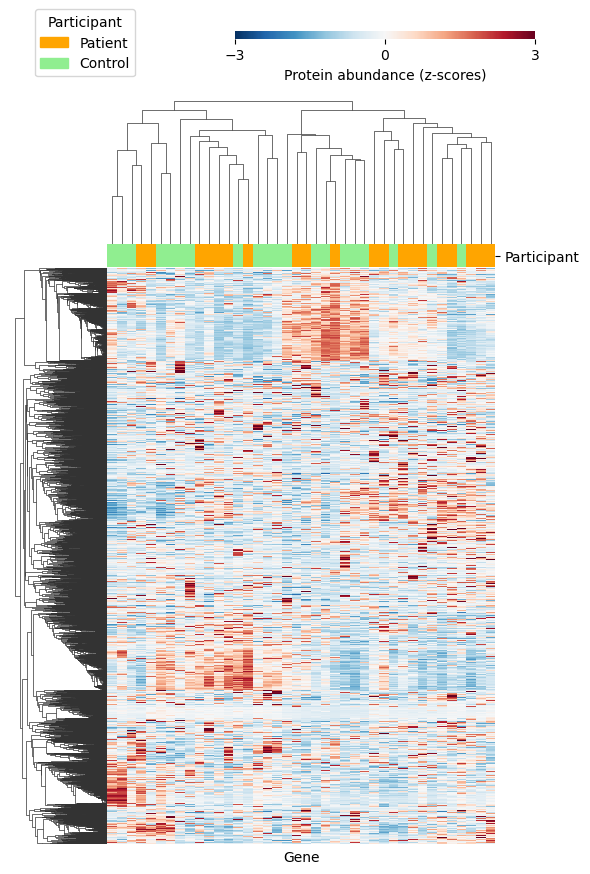

In [17]:
min_color = -3
max_color = 3

hm_average = sns.clustermap(data=df_nolabels,
          method="average",
          metric="correlation",
          xticklabels=[],
          yticklabels=[],
          vmin=min_color,
          vmax=max_color,
          cmap="RdBu_r",
          cbar_pos=(0.4, 1.05, 0.50, 0.01),
          cbar_kws={'orientation': 'horizontal', 'ticks': [min_color, 0, max_color], 'label': 'Protein abundance (z-scores)'},
          col_colors=col_colors,
          figsize=(6, 8))

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_patches, loc='center', bbox_to_anchor=(-0.50, -0.50), title="Participant")

# Volcano plot

In [6]:
# create a df of the df dataframe of the columns that are participant row = "patient"
patient_df = df_transposed[df_transposed['Participant'] == 'Patient']
patient_df = patient_df.drop('Participant', axis=1)
patient_df.index.name = None
patient_df

Gene,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAGAB,AARS,AASDHPPT,ABCC6,...,ZNF774,ZNF843,ZNRF3,ZP4,ZPBP,ZPBP2,ZPLD1,ZWILCH,ZWINT,ZYX
P1,-0.208129,-0.419017,-0.369464,-0.681827,0.59253,-0.272978,1.879046,-0.09897,-0.029837,0.646728,...,-1.430593,0.427947,-0.099927,-0.537459,-1.211915,0.368769,-0.076636,-1.356742,-1.241407,-0.567953
P2,-0.598398,5.793107,1.399792,0.323497,0.229079,0.384998,-0.82514,-0.430588,-0.649539,0.535298,...,-1.23201,-0.283659,-0.046636,-0.175699,-1.23284,0.884795,0.073319,-0.748043,-0.509283,-0.812421
P4,0.899881,-0.085295,-0.371183,1.505926,0.065202,-0.330493,-1.081448,-0.993522,-1.094909,-0.448857,...,1.930746,-0.090478,4.187202,-0.315165,2.41701,-0.054656,-0.120418,2.605768,1.050719,-1.169851
P6,0.114559,0.033296,-1.117822,-0.42087,4.052755,-0.207293,-0.68444,-0.709207,-1.062318,0.465183,...,-0.480772,0.29324,-0.161139,-0.161491,-0.670412,1.739867,-0.20547,-0.426434,-0.985067,-1.217936
P9,-0.061617,-0.154599,0.368761,-0.587867,1.023772,-0.199223,-0.49155,-0.448963,-0.496959,0.479745,...,0.529766,1.239279,2.837399,-0.424211,-0.828762,1.107536,-0.147179,-0.719847,-1.571345,-0.528291
P11,0.287414,-0.432669,-0.826427,-0.532369,0.447598,-0.395434,2.751083,0.046192,0.177629,-0.005303,...,-1.510129,1.901329,-0.291886,-0.330991,-0.825648,-0.01363,-0.573801,-0.506147,-0.655907,0.373342
P13,-0.266023,-0.775257,0.092247,-0.897585,-0.549563,-0.41006,-0.590066,-0.519277,0.137447,-0.522038,...,-0.567213,-0.5807,-0.250029,0.815275,-0.364532,-0.463433,-0.05783,-1.175183,-0.715094,0.1136
P17,-0.818057,-0.668044,-1.048939,-0.857524,-0.883984,-0.655448,1.326943,1.464248,1.874463,1.768249,...,-1.103605,-0.023181,-0.398468,-0.255006,-0.776821,-0.55578,-0.613502,-0.94008,0.342927,1.371669
P18,-0.406598,-0.351571,-1.600334,0.432672,0.049496,-0.323739,0.410688,-0.198533,-0.396266,-0.495586,...,0.027558,-0.871791,-0.110104,-0.330207,1.600546,-0.7101,-0.493255,2.051009,0.61221,-0.817448
P19,0.967735,-0.333792,-1.483959,-0.119935,1.193068,-0.344252,-0.730647,0.063211,-0.100029,-0.016741,...,-0.590776,-0.676344,-0.19518,-0.382491,-0.016696,-0.517594,-0.288046,0.050747,2.205883,-0.685597


In [7]:

# create a df of the df dataframe of the rows that are participant row = "control"
control_df = df_transposed[df_transposed['Participant'] == 'Control']
control_df = control_df.drop('Participant', axis=1)
control_df.index.name = None
control_df

Gene,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAGAB,AARS,AASDHPPT,ABCC6,...,ZNF774,ZNF843,ZNRF3,ZP4,ZPBP,ZPBP2,ZPLD1,ZWILCH,ZWINT,ZYX
C1,0.091205,-0.366126,-1.446105,-0.549432,-0.536944,-0.299501,-0.292182,-0.820226,-0.587184,-0.819323,...,0.1605,-0.754402,-0.207058,0.080058,0.843044,-0.394226,0.16983,1.073171,-0.474608,-1.442735
C2,7.078895,-0.189053,0.419728,-0.361978,0.003758,-0.228679,-0.94904,-0.855227,-0.900711,-0.286599,...,-0.285183,-0.231702,0.21365,0.145059,0.251875,-0.187077,0.733269,0.101965,-0.240045,1.236425
C3,1.069358,-0.191105,0.994347,0.448254,-0.98269,0.026621,-1.02467,-0.842347,-1.039194,-1.054956,...,0.584928,-0.718431,-0.022314,0.891907,1.223247,-1.03287,-0.064138,0.978747,-0.256897,-0.46137
C4,-0.410483,-0.447277,0.976399,-0.608533,0.05802,-0.271733,-0.146542,-0.475757,-0.593619,-0.152482,...,-0.702408,-0.438253,-0.096045,0.068312,0.56409,0.442088,0.053915,1.12973,0.674238,1.033261
C5,0.090994,-0.284493,-0.790543,0.232591,-0.989209,-0.150768,-0.911654,-0.637662,-0.770396,0.531415,...,0.916792,1.699661,-0.181916,-0.083498,2.361521,-1.254042,-0.254261,1.329205,0.231543,-0.825308
C8,-0.391397,-0.293338,-0.042582,-0.514884,-1.274313,-0.337742,-0.596134,-0.600139,0.039612,-0.084929,...,0.826742,0.227097,-0.317169,0.094485,-0.579469,-0.372421,-0.435583,-0.540338,-0.765723,-0.616618
C9,-0.482971,-0.274342,-0.595659,-0.505113,-0.747419,-0.189681,-0.652587,-0.548021,-0.779703,-0.43508,...,0.562107,-0.354712,-0.282411,-0.258266,0.428934,-0.300965,0.099608,0.981353,-0.48687,-0.646738
C11,0.155578,-0.461104,-0.083005,0.029682,-0.468004,-0.213198,-0.468214,-0.374098,-0.073537,-1.128378,...,0.993073,-1.011909,-0.214178,-0.168294,0.54777,-0.504577,-0.272006,0.572758,-0.678586,0.322707
C14,0.292637,-0.713775,-1.679806,-0.819734,-0.820285,-0.420879,1.022425,0.395356,0.956157,-0.724259,...,-0.229078,-0.614061,-0.314105,-0.328098,0.353571,-0.698374,6.092002,0.461969,-0.057444,0.302116
C15,0.16033,1.576058,0.217666,-0.058552,0.488821,-0.422026,1.178486,1.909698,1.309975,-0.049642,...,2.577078,-0.891237,-0.359296,-0.631328,-0.464839,1.945627,-0.531452,-0.545974,0.34744,0.462984


In [8]:
# coerce to numeric
patient_df = patient_df.apply(pd.to_numeric, errors = 'coerce')
control_df = control_df.apply(pd.to_numeric, errors = 'coerce')

Gene,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAGAB,AARS,AASDHPPT,ABCC6,...,ZNF774,ZNF843,ZNRF3,ZP4,ZPBP,ZPBP2,ZPLD1,ZWILCH,ZWINT,ZYX
P1,-0.208129,-0.419017,-0.369464,-0.681827,0.592530,-0.272978,1.879046,-0.098970,-0.029837,0.646728,...,-1.430593,0.427947,-0.099927,-0.537459,-1.211915,0.368769,-0.076636,-1.356742,-1.241407,-0.567953
P2,-0.598398,5.793107,1.399792,0.323497,0.229079,0.384998,-0.825140,-0.430588,-0.649539,0.535298,...,-1.232010,-0.283659,-0.046636,-0.175699,-1.232840,0.884795,0.073319,-0.748043,-0.509283,-0.812421
P4,0.899881,-0.085295,-0.371183,1.505926,0.065202,-0.330493,-1.081448,-0.993522,-1.094909,-0.448857,...,1.930746,-0.090478,4.187202,-0.315165,2.417010,-0.054656,-0.120418,2.605768,1.050719,-1.169851
P6,0.114559,0.033296,-1.117822,-0.420870,4.052755,-0.207293,-0.684440,-0.709207,-1.062318,0.465183,...,-0.480772,0.293240,-0.161139,-0.161491,-0.670412,1.739867,-0.205470,-0.426434,-0.985067,-1.217936
P9,-0.061617,-0.154599,0.368761,-0.587867,1.023772,-0.199223,-0.491550,-0.448963,-0.496959,0.479745,...,0.529766,1.239279,2.837399,-0.424211,-0.828762,1.107536,-0.147179,-0.719847,-1.571345,-0.528291
P11,0.287414,-0.432669,-0.826427,-0.532369,0.447598,-0.395434,2.751083,0.046192,0.177629,-0.005303,...,-1.510129,1.901329,-0.291886,-0.330991,-0.825648,-0.013630,-0.573801,-0.506147,-0.655907,0.373342
P13,-0.266023,-0.775257,0.092247,-0.897585,-0.549563,-0.410060,-0.590066,-0.519277,0.137447,-0.522038,...,-0.567213,-0.580700,-0.250029,0.815275,-0.364532,-0.463433,-0.057830,-1.175183,-0.715094,0.113600
P17,-0.818057,-0.668044,-1.048939,-0.857524,-0.883984,-0.655448,1.326943,1.464248,1.874463,1.768249,...,-1.103605,-0.023181,-0.398468,-0.255006,-0.776821,-0.555780,-0.613502,-0.940080,0.342927,1.371669
P18,-0.406598,-0.351571,-1.600334,0.432672,0.049496,-0.323739,0.410688,-0.198533,-0.396266,-0.495586,...,0.027558,-0.871791,-0.110104,-0.330207,1.600546,-0.710100,-0.493255,2.051009,0.612210,-0.817448
P19,0.967735,-0.333792,-1.483959,-0.119935,1.193068,-0.344252,-0.730647,0.063211,-0.100029,-0.016741,...,-0.590776,-0.676344,-0.195180,-0.382491,-0.016696,-0.517594,-0.288046,0.050747,2.205883,-0.685597


In [9]:
# 1. replace 0 with NaN
patient_df.replace(0, np.nan, inplace = True)
control_df.replace(0, np.nan, inplace = True)

# 2. find the minimum non-zero value in the df
patient_min = patient_df[patient_df > 0].min().min()
control_min = control_df[control_df > 0].min().min()

# 3. take a third of the minimum non-zero value
patient_replacement = patient_min / 3
control_replacement = control_min / 3

# 4. replace NaN with the third of the minimum non-zero value
patient_df = patient_df.fillna(patient_replacement)
control_df = control_df.fillna(control_replacement)

In [10]:
# compute p-value w a two-tailed, equal variance Student's t-test
t_stat, p_values = ttest_ind(patient_df, control_df, equal_var=True, axis=1)


In [11]:
p_values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [ ]:

# Calculate log2 fold change (x-axis)
x_axis = (patient_df.mean(axis=1) / control_df.mean(axis=1))

# perform Benjamini-Hochberg correction
corrected_p_values = multipletests(p_values, method='fdr_bh', alpha=0.05)[1]

# Calculate -log10 of p_value (y-axis)
y_axis= -1 * np.log10(corrected_p_values)

# Create figure
plt.figure(figsize=(10, 8))
plt.scatter(x_axis, y_axis, color='black', s=3)
plt.xlabel('mRNA Abundance Ratio Between the Patient and Control')
plt.ylabel('-log10(p-value)')

plt.xlim(-20, 20)
plt.ylim(0, 120)
plt.show()


# Correlation analysis

In [18]:
# amongst all Participants = Patient, find the top 20 with the highest mean value
df_patient = df.loc[:, df.loc['Participant'] == 'Patient']
df_patient = df_patient.drop('Participant')
df_patient = df_patient.apply(pd.to_numeric)
df_patient = df_patient.mean(axis=1)
df_patient = df_patient.sort_values(ascending=False)

In [20]:
# get list of unique genes
genes = df.index[:-1].unique().sort_values(ascending = True)
genes

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAGAB', 'AARS',
       'AASDHPPT', 'ABCC6',
       ...
       'ZPBP2', 'ZPLD1', 'ZWILCH', 'ZWINT', 'ZYX', 'apcA apcB', 'magainins',
       'mdh', 'nodH', 'non-human'],
      dtype='object', name='Gene', length=4735)

In [21]:
df_nolabels_t = df_nolabels.T
corr = df_nolabels_t.corr()

In [22]:
# ignoring corr = 1.00, get the top 20 correlations
corr = corr.mask(np.tril(np.ones(corr.shape)).astype(bool))
corr = corr.stack().sort_values(ascending=False)
corr.head(20)

LCAT         UBE2D3      0.998040
FTH1 FTL     FTL         0.996625
LCAT         MFAP3L      0.996246
ARL6         GCK         0.996154
             LCAT        0.995821
             MFAP3L      0.995626
MFAP3L       UBE2D3      0.995047
ARL6         NAALADL1    0.994873
CHFR         MFAP3L      0.994834
ARL6         UBE2D3      0.994593
             PPA2        0.994223
             CHFR        0.994191
GCK          NAALADL1    0.994026
CDK5 CDK5R1  TPM2        0.993802
CHFR         LCAT        0.993555
ARL6         HPGD        0.993545
CHFR         NAALADL1    0.993454
HPGD         PPA2        0.993453
MFAP3L       NAALADL1    0.993343
             PARP16      0.993256
dtype: float64

In [29]:
gene_of_interest = "LCAT"
correlations = corr.loc[:, gene_of_interest]
ranked_correlations = correlations.sort_values(ascending = False)

# export the top 100 correlations to a txt file, keeping column 0 only
ranked_correlations.to_csv(f'top100_correlations_{gene_of_interest}.txt', sep='\t', header=False)

# remove the numbers from the text file
with open(f'top100_correlations_{gene_of_interest}.txt', 'r') as f:
    lines = f.readlines()
    lines = [line.split('\t')[0] for line in lines]
    lines = [line + '\n' for line in lines]
    lines = lines[0:100]

with open(f'top100_correlations_{gene_of_interest}.txt', 'w') as f:
    f.writelines(lines)